<h1>Exploring Cryptocurrency with Python (work in progress)</h1>

This project will look at cryptocurrency from a data-driven approach. Most code will be written in python to utilize dataframes and the analysis capabilities it brings. Much of our data will be pulled from the Binance API https://github.com/binance-exchange. Binance is one of the leading cryptocurrency exchanges and provides access to useful information about all of their cryptocurrencies listed. Information such as Open time, daily highs, daily lows, opening and closing prices, much of the information we need to do analysis can be pulled from the Binance API. 

Binance has a python wrapper that we can utilize to pull data we need https://github.com/binance-exchange/python-binance.

<h3>Step 0.1 - Import the Dependencies</h3>
</p>
Let's start by importing required dependencies.

In [1]:
import time
#import dateparser
import pytz
import json

from datetime import datetime

from binance.client import Client
client = Client("", "")

In [2]:
import numpy as np
import pandas as pd
import pickle

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

<h1>Step 1 - Retrieve Cryptocurrency Data from Binance</h1>

<h3>step 1.1 - Write function to Download/Load Currency Data</h3>
</p>
Next we will write a helper function that downloads and caches individual ticker information from the Binance API. The function first tries to load a dataframe from a cached file, if the file does not exist it downloads real time data from the Binance API and caches it to a file for next time. 



In [4]:

def get_symbol_df(symbol, time_interval, start_time, end_time = None):
    '''Download and cache Binance data for given symbol pair like ETHBTC'''
    
    cache_path = '{} {} {}.pkl'.format(symbol, time_interval, start_time)
    try:
        f = open(cache_path, 'rb')
        data_df = pickle.load(f)
        print('Loaded {} from cache'.format(symbol))
        
    except(OSError, IOError) as e:
        print('Downloading {} from Binance'.format(symbol))
    
        #get symbol data from binance 
        candles = client.get_historical_klines(symbol, time_interval, start_time, end_time)
    
        #labels for dataframe
        labels = ['Open time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close time', 'Quote asset volume', 'Number of trades',
         'Taker buy base asset volume', 'Taker buy quote asset volume', 'Ignore']

        #populate database with symbols info
        data_df = pd.DataFrame(candles, columns=labels)
    
        #convert timestamp 
        data_df['Open time'] = pd.to_datetime(data_df['Open time'].div(1000), unit='s')
        data_df['Close time'] = pd.to_datetime(data_df['Close time'].div(1000), unit='s')
        
        data_df.to_pickle(cache_path)
        print('Cached {} at {}'.format(symbol, cache_path))
    
    return data_df
 


<h3>Step 1.2 - Write Function to Prepare a List of Ticker Pairs</h3>
</p>
This function downloads and returns currently listed pairs of currencies from Bianance. We pass it one of the mainstream coins such as 'BTC' or 'ETH' to get a list of all symbol pairs associated with the base ticker.

In [5]:
def get_all_symbol_pairs(base):
    '''Returns list of symbol pairs for given base
    (would be easy to edit the code to add the most up to date price also)'''
    
    #get live ticker pairs currently listed on binance
    prices = client.get_all_tickers()
    
    symbol_list = []
    for d in prices:
        
        #if trailing 3 characters == base_symbol add the symbol pair and return list
        if(d['symbol'][-3:] == base):
            symbol_list.append(d['symbol'])
            
    return symbol_list

<h3>Step 1.3 - Get a Dictionary of Specified Ticker Pairs</h3>
</p>
Here we use the 2 functions from above to create and return a dictionary of ticker pairs as the keys, and the ticker dataframe as the values. The function takes the base ticker symbol (i.e. 'BTC'), time_interval like Client.KLINE_INTERVAL_4HOUR, start_time like '2017-01-01' and other optional parameters.

In [6]:
def get_all_symbol_df(base_symbol, time_interval, start_time, end_time = None, add_usd = True, cap = 10):
    '''Returns dictionary of dataframes of symbol pairs'''
    
    #use following line to get an updated list
    symbol_pairs = get_all_symbol_pairs(base_symbol)
    #symbol_pairs = btc_pairs
    
    dict_df = {}
    #get a dataframe of all symbol_pairs populated into a list
    for symbol in symbol_pairs:

        data_df = get_symbol_df(symbol, time_interval, start_time)
        data_df['ticker'] = symbol
       
        #add usd column
        if(add_usd):
            #this runs multi times when it doesn't need to....fix it later
            data_df = get_usd_price(data_df, time_interval)
        
        data_df = data_df.set_index('Open time')
        dict_df[symbol]  = data_df
        
        #####cap data amount for testing purposes. remove later 
        if(len(dict_df) >= cap):
            print(cap)
            return dict_df
        
    return dict_df

<h3>Step 1.4 - Write Function to Pull USD Price for Coin</h3>
</p>
Finally, this helper function merges the USDT price of to the currency dataframe. USDT stands for USD tether, which is a cryptocurrency that closely tethers USD. We must be mindful that USDT does not perfectly tether USD and therefore is not the perfect representation of USD. However, for the purpose of this project it mirrors USD close enough that we will treat it as USD. 

In [7]:
#BTCUSDT only starts from 2017-08-17 for binance so we lose a month of data, 
#also USDT is not USD. Although it is tethered to USD it deviates depending on supply/demand
#we could pull true USD/BTC rates from other exchanges, but for our MVP this should be fine

def get_usd_price(df, interval):
    '''return df with usdt price added as column'''
    
    btc_usdt = get_symbol_df('BTCUSDT', interval, '2017-01-01')
    btc_usdt = btc_usdt.drop(columns=['Open', 'High', 'Low', 'Volume', 'Close time', 
                                      'Quote asset volume','Number of trades', 
                                      'Taker buy base asset volume', 
                                      'Taker buy quote asset volume','Ignore'])
    
    #use inner here since usdt data starts on 2018-08-17 and was pulled more recently
    df =df.merge(btc_usdt, left_on='Open time', right_on = 'Open time', how='inner')
    
    df['Usd'] = round(df['Close_x'].astype(float) * df['Close_y'].astype(float), 2)
    df = df.drop(columns ='Close_y')
    df = df.rename(columns={"Close_x": "Close"})
    
    return df

<h3>Step 1.5 - Downloading Real Data from Binance</h3>
</p>
With our helper functions setup we can now start downloading BTC pair information. We will start with 4 hour intervals to see if anything interesting happens during this time frame. We can also get daily, 12hour, 1hour, 5min and even 1min intervals but 4hours seems like a good starting point. There are currently 121 BTC pair coins on Binance, but we will start with 21 first and expand the number of pairs later.

In [8]:
#dictionary of all BTC pairs in 4 hour intervals
#key = ticker pair , values = df 
btc_4hour_dict = get_all_symbol_df('BTC', Client.KLINE_INTERVAL_4HOUR, "2017-01-01", None, True, 21)

Loaded ETHBTC from cache
Loaded BTCUSDT from cache
Loaded LTCBTC from cache
Loaded BTCUSDT from cache
Loaded BNBBTC from cache
Loaded BTCUSDT from cache
Loaded NEOBTC from cache
Loaded BTCUSDT from cache
Loaded BCCBTC from cache
Loaded BTCUSDT from cache
Loaded GASBTC from cache
Loaded BTCUSDT from cache
Loaded HSRBTC from cache
Loaded BTCUSDT from cache
Loaded MCOBTC from cache
Loaded BTCUSDT from cache
Loaded WTCBTC from cache
Loaded BTCUSDT from cache
Loaded LRCBTC from cache
Loaded BTCUSDT from cache
Loaded QTUMBTC from cache
Loaded BTCUSDT from cache
Loaded YOYOBTC from cache
Loaded BTCUSDT from cache
Loaded OMGBTC from cache
Loaded BTCUSDT from cache
Loaded ZRXBTC from cache
Loaded BTCUSDT from cache
Loaded STRATBTC from cache
Loaded BTCUSDT from cache
Loaded SNGLSBTC from cache
Loaded BTCUSDT from cache
Loaded BQXBTC from cache
Loaded BTCUSDT from cache
Loaded KNCBTC from cache
Loaded BTCUSDT from cache
Loaded FUNBTC from cache
Loaded BTCUSDT from cache
Loaded SNMBTC from cache


<h3>Step 1.6 - Explore Data</h3>
</p>
Here we will Explore our data with Basic dictionary and pandas commands.

In [9]:
btc_4hour_dict.keys()

dict_keys(['YOYOBTC', 'KNCBTC', 'BNBBTC', 'BQXBTC', 'LRCBTC', 'SNMBTC', 'BCCBTC', 'GASBTC', 'WTCBTC', 'LTCBTC', 'QTUMBTC', 'IOTABTC', 'HSRBTC', 'ETHBTC', 'FUNBTC', 'STRATBTC', 'SNGLSBTC', 'OMGBTC', 'ZRXBTC', 'NEOBTC', 'MCOBTC'])

Great, the dictionary contains BTC symbol pairs as the keys and dataframes as values. Now that our dictionary is loaded with dataframes, let's try accessing and exploring one of them. We will start with 'ETHBTC' since these currencies have the largest market capitalization and are also the most commonly known.

In [10]:
btc_4hour_dict['ETHBTC'].shape

(1490, 13)

In [11]:
btc_4hour_dict['ETHBTC'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1490 entries, 2017-08-17 04:00:00 to 2018-04-23 16:00:00
Data columns (total 13 columns):
Open                            1490 non-null object
High                            1490 non-null object
Low                             1490 non-null object
Close                           1490 non-null object
Volume                          1490 non-null object
Close time                      1490 non-null datetime64[ns]
Quote asset volume              1490 non-null object
Number of trades                1490 non-null int64
Taker buy base asset volume     1490 non-null object
Taker buy quote asset volume    1490 non-null object
Ignore                          1490 non-null object
ticker                          1490 non-null object
Usd                             1490 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(10)
memory usage: 163.0+ KB


In [12]:
btc_4hour_dict['ETHBTC'].head()

,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Ignore,ticker,Usd
Open time,,,,,,,,,,,,,
2017-08-17 04:00:00,0.07058200,0.07158200,0.06986700,0.07109400,4021.53900000,2017-08-17 07:59:59.999,283.55430669,3117,1950.58800000,137.64451024,46884.54339102,ETHBTC,309.26
2017-08-17 08:00:00,0.07088100,0.07122900,0.06883000,0.06940600,3403.20800000,2017-08-17 11:59:59.999,238.55234849,2984,1552.15500000,108.75034780,46866.63079951,ETHBTC,307.28
2017-08-17 12:00:00,0.06940600,0.07130400,0.06807700,0.07056100,5091.01200000,2017-08-17 15:59:59.999,353.53825545,4190,2497.76000000,173.62711426,47528.18909052,ETHBTC,307.11
2017-08-17 16:00:00,0.07023900,0.07225400,0.06959600,0.07012400,4916.10800000,2017-08-17 19:59:59.999,348.75722631,4351,2317.15100000,164.06176172,48886.75337014,ETHBTC,303.30
2017-08-17 20:00:00,0.07012400,0.07147500,0.06988900,0.07047900,3883.15300000,2017-08-17 23:59:59.999,273.59459740,4134,2017.00900000,142.12884692,50579.87228839,ETHBTC,302.01


Great, we have a dictionary with individual currencies as the value. 


<h3>Step 1.7 - Create a new column for Pump & Dumps</h3>

<p>
The Pump & Dump(P&D) is an age old scheme that pumps the price of a cryptocurrency and once the price has peaked the organizers of the P&D sell the overpriced cryptocurrency onto less savvy buyers. Because of the new and unregulated nature of the current cryptocurrency markets, There are many of these P&D groups creating artificial spikes in the price at an alarming rate. We will keep track of these spikes in price and do further analysis on P&Ds later.
</p>
<p>
The definition of a P&D for our purposes will be, although simplistic, a 10% or larger spike in the value of a currency, followed by a similiar percentage drop within a 4 hour interval. This can be measured by (high/close - 1). We will calculate then add a P&D percentage to each row of the dataframe.
</p>

In [13]:
def add_pnd_column(df, percentage = 0):
    '''add pnd column by High - Close. filter by percentage'''
    
    df['PnD'] = round(df['High'].astype(float)/df['Close'].astype(float) - 1, 4)
    df = df[(df.PnD >= percentage)]
    
    return df

With our P&D helper function will iterate over each dataframe adding a pnd column

In [14]:
#add a pnd column for each df
pnd_4hour = {}
for k , v in btc_4hour_dict.items():
    pnd_4hour[k] = add_pnd_column(btc_4hour_dict[k], .1)


<h3>Step 1.8 - Drop unnecessary columns</h3>
</p>
Finally, with the P&D column added, we can drop columns that we won't be using.

In [15]:
#drop unwanted columns
for k , v in pnd_4hour.items():
    pnd_4hour[k] = pnd_4hour[k].drop(columns = ['Close time', 'Quote asset volume',
                                             'Taker buy base asset volume', 'Taker buy quote asset volume','Ignore'])

In [16]:
pnd_4hour['ETHBTC']

,Open,High,Low,Close,Volume,Number of trades,ticker,Usd,PnD
Open time,,,,,,,,,
2017-08-22 00:00:00,0.08068800,0.08450000,0.07175700,0.07200000,10372.53600000,8015,ETHBTC,278.09,0.1736
2017-11-08 20:00:00,0.04422800,0.04600000,0.04141800,0.04142100,14210.14500000,9593,ETHBTC,302.50,0.1105
2017-11-12 04:00:00,0.05001800,0.05400000,0.04760000,0.04890000,33510.29700000,21606,ETHBTC,296.33,0.1043
2017-12-07 12:00:00,0.02909600,0.02930500,0.02597800,0.02601400,34688.06300000,31123,ETHBTC,398.27,0.1265
2017-12-07 20:00:00,0.02684100,0.02778800,0.02425100,0.02456500,22700.79400000,24938,ETHBTC,407.75,0.1312
2017-12-08 04:00:00,0.02550900,0.02866500,0.02498200,0.02580600,30464.57400000,33090,ETHBTC,409.80,0.1108
2017-12-10 12:00:00,0.03172600,0.03200000,0.02840000,0.02888600,30992.95600000,30156,ETHBTC,444.84,0.1078
2017-12-14 08:00:00,0.04484500,0.04650000,0.04100000,0.04227300,94754.11600000,72395,ETHBTC,680.55,0.1000
2017-12-15 00:00:00,0.04155000,0.04166000,0.03350100,0.03747900,69008.24100000,63207,ETHBTC,641.60,0.1116


For good measure, we checked our ETHBTC dataframe and all looks good! We are ready to move along to the next part of our analysis.

<h1>Step 2 - Visual Exploratory Data Analysis</h1>

In this step we will be diving into our data to through visual EDA. There are many aspects that our best suited to be visually represented, especially in larger datasets like our own. Let's dive in and see what we can find.

<h3>Step 2.1 - Plot Cryptocurrencies</h3>
</p>
Here we will start by overlaying a plot of all our currency pairs. This is just to get a quick look at how the data looks side by side to see if anything stands out.

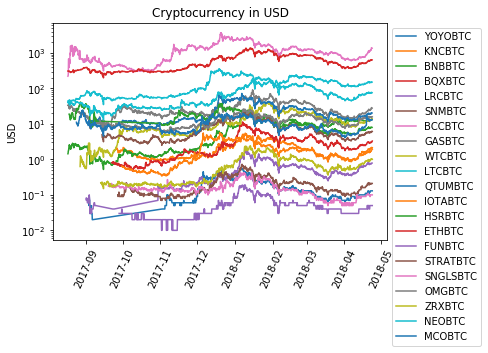

In [17]:
#Plot Cryptocurrency in USD
for k, v in btc_4hour_dict.items():
    
    plt.plot(v.index, v['Usd'], label = k)
    plt.yscale('log')
    plt.xticks(rotation='65')

plt.title('Cryptocurrency in USD')
plt.ylabel('USD')
plt.legend(bbox_to_anchor=(1, 1))    
plt.show()

Great we can visually see each coins movements, but the graph doesn't tell an amazing story of what is going on. Let's use a heatmap to visualize how currencies are related to one another.



<h3>Step 2.2 - Define Function to Merge Dataframes on Columns</h3>
</p>
First we will define a helper function that merges dataframe columns and returns a single dataframe with the merged columns. We will use this in the next step to isolate the USD columns from each dataframe and create a new dataframe.

In [18]:
def merge_dfs_on_column(dataframes, labels, col):
    '''Merge a single column of each dataframe into a new combined dataframe'''
    series_dict = {}
    for index in range(len(dataframes)):
        series_dict[labels[index]] = dataframes[index][col]
        
    return pd.DataFrame(series_dict)

<h3>Step 2.3 - Create new USD Dataframe</h3>
</p>
Now that the dataframe is defined let's use it to merge all USD columns from each currency pair as a new dataframe.

In [19]:
#combine df consisting of each currency in USD
combined_df = merge_dfs_on_column(list(btc_4hour_dict.values()), 
                                        list(btc_4hour_dict.keys()), 'Usd' )

In [20]:
combined_df.tail()

,BCCBTC,BNBBTC,BQXBTC,ETHBTC,FUNBTC,GASBTC,HSRBTC,IOTABTC,KNCBTC,LRCBTC,...,MCOBTC,NEOBTC,OMGBTC,QTUMBTC,SNGLSBTC,SNMBTC,STRATBTC,WTCBTC,YOYOBTC,ZRXBTC
Open time,,,,,,,,,,,,,,,,,,,,,
2018-04-23 04:00:00,1403.96,13.07,3.09,641.13,0.05,28.85,8.03,2.09,1.80,0.78,...,13.16,77.80,15.70,20.66,0.1,0.21,5.97,13.73,0.13,1.02
2018-04-23 08:00:00,1396.96,13.73,3.09,636.83,0.05,27.96,8.13,2.18,1.88,0.78,...,13.34,76.96,15.57,20.48,0.1,0.21,6.20,13.69,0.13,1.03
2018-04-23 12:00:00,1397.88,13.46,3.11,645.82,0.05,28.12,8.10,2.10,1.89,0.79,...,12.95,76.22,15.50,20.26,0.1,0.21,6.05,13.84,0.13,1.01
2018-04-23 16:00:00,1362.66,13.46,3.14,639.46,0.05,27.82,8.00,2.08,1.92,0.79,...,13.00,75.90,15.64,20.29,0.1,0.21,6.06,13.99,0.13,0.99
2018-04-23 20:00:00,NaN,NaN,3.30,NaN,0.05,NaN,NaN,2.12,1.93,NaN,...,NaN,NaN,15.82,NaN,0.1,0.21,6.11,NaN,0.13,1.00


Looks good! now we can find the correlations between each pair 

In [21]:
df_corr = combined_df.pct_change().corr(method='pearson')

In [22]:
df_corr

,BCCBTC,BNBBTC,BQXBTC,ETHBTC,FUNBTC,GASBTC,HSRBTC,IOTABTC,KNCBTC,LRCBTC,...,MCOBTC,NEOBTC,OMGBTC,QTUMBTC,SNGLSBTC,SNMBTC,STRATBTC,WTCBTC,YOYOBTC,ZRXBTC
BCCBTC,1.000000,0.235656,0.358264,0.287748,0.186690,0.221372,0.195861,0.394903,0.436226,0.145456,...,0.305752,0.255781,0.516982,0.507544,0.244762,0.318025,0.483626,0.329646,0.220255,0.407421
BNBBTC,0.235656,1.000000,0.414747,0.593719,0.247848,0.448117,0.488499,0.451921,0.488838,0.360413,...,0.457783,0.540779,0.584005,0.647529,0.308997,0.383169,0.549372,0.472898,0.388189,0.477055
BQXBTC,0.358264,0.414747,1.000000,0.553072,0.251137,0.446734,0.476486,0.466386,0.476561,0.341730,...,0.389432,0.512482,0.521906,0.481148,0.303804,0.445303,0.494179,0.445963,0.317182,0.440341
ETHBTC,0.287748,0.593719,0.553072,1.000000,0.293235,0.556509,0.532855,0.603995,0.656665,0.423792,...,0.550054,0.716772,0.766638,0.720572,0.408631,0.468333,0.682974,0.511231,0.404666,0.610494
FUNBTC,0.186690,0.247848,0.251137,0.293235,1.000000,0.225602,0.291805,0.268225,0.261729,0.154043,...,0.206416,0.262580,0.269104,0.264458,0.149095,0.196672,0.302657,0.243689,0.150151,0.269381
GASBTC,0.221372,0.448117,0.446734,0.556509,0.225602,1.000000,0.461720,0.499337,0.539287,0.346105,...,0.414727,0.743814,0.603892,0.541329,0.336113,0.390208,0.522029,0.358852,0.366694,0.422754
HSRBTC,0.195861,0.488499,0.476486,0.532855,0.291805,0.461720,1.000000,0.486844,0.542928,0.470131,...,0.395715,0.543900,0.595144,0.625191,0.370588,0.422448,0.591733,0.404076,0.392795,0.460539
IOTABTC,0.394903,0.451921,0.466386,0.603995,0.268225,0.499337,0.486844,1.000000,0.496567,0.294868,...,0.415639,0.543074,0.569305,0.527748,0.341237,0.428567,0.551666,0.477499,0.374056,0.434893
KNCBTC,0.436226,0.488838,0.476561,0.656665,0.261729,0.539287,0.542928,0.496567,1.000000,0.394548,...,0.431027,0.601801,0.625246,0.552614,0.423597,0.429470,0.598311,0.497921,0.343855,0.499829
LRCBTC,0.145456,0.360413,0.341730,0.423792,0.154043,0.346105,0.470131,0.294868,0.394548,1.000000,...,0.296643,0.388699,0.398547,0.353585,0.292875,0.317820,0.400455,0.283418,0.421689,0.346055


We can see that cryptocurrencies are generally correlated. Let's try visualizing the pearson correlation coefficients in a heatmap to help interpret our findings.

In [23]:
df_corr = combined_df.pct_change().corr(method='pearson')

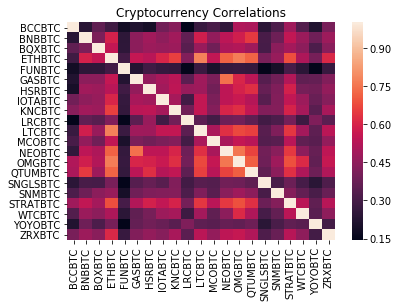

In [24]:
heatmap = sns.heatmap(df_corr)
plt.title('Cryptocurrency Correlations')
plt.show()

For the most part, the above heatmap signifies that there is indeed correlation between cryptocurrencies. Initially FUN and BCC stands out from the bunch since they are less correlated with all other currencies. I know BCC has stop trading for the most part from fraudulant activity. For FUN coin I am not entirely sure why it has lower correlation, maybe we can dig deeper later.

Apart from several currencies, most currencies are correlated with one another. Let's see if there are any correlation differences from 2017 to 2018.

In [25]:
combined_df_2017 = combined_df[combined_df.index.year == 2017]
df_corr_2017 = combined_df_2017.pct_change().corr(method='pearson')
combined_df_2018 = combined_df[combined_df.index.year == 2018]
df_corr_2018 = combined_df_2018.pct_change().corr(method='pearson')

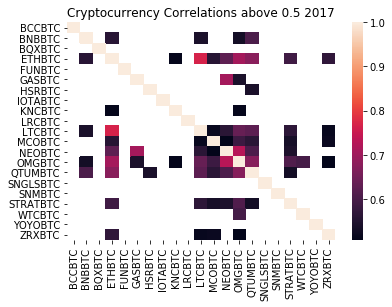

In [26]:
heatmap = sns.heatmap(df_corr_2017.where(df_corr_2017 > .5))
plt.title('Cryptocurrency Correlations above 0.5 2017')
plt.show()

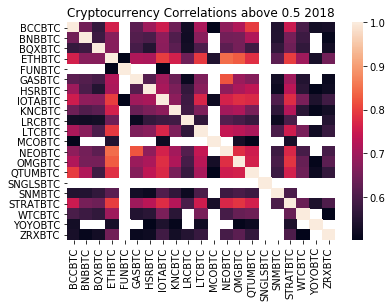

In [27]:
heatmap = sns.heatmap(df_corr_2018.where(df_corr_2018 > .5))
plt.title('Cryptocurrency Correlations above 0.5 2018')
plt.show()

We can see immediately that stronger correlations between cryptocurrencies has increased in numbers in 2018.

In [28]:
#which days of the week does the price go up the most on average? percentage change from 1day to another 

'''plot 5 things: correlation map, seasonality...hist by month, moving avg, volume for pivot points '''
'''get marketcap info so we can analyze not just on price fluctuation but capitalization as a whole'''

'get marketcap info so we can analyze not just on price fluctuation but capitalization as a whole'

In [29]:
# fastest growing coin? use histograms!
#can we find the fastest growing coin?

In [30]:
#do tutorial first though...maybe we can sort the lines out in above graph without plot.ly
#rewatch datacamp visualization vids
#setup github through nbviewer so plot.ly can be used

<h5>Correlation analysis</h5>


In [31]:
# ///feed back
# do more wrangling , analysis how is volume very on exchanges
# how does volume high volitility or low volitility, price going up or down on those days?
# answer questions in wragnling...what data r we getting and doing and answering
# right down what we r doing in comments 
 
# introduction what it is wat is the goal 3-5 high level questions
# verbouse more words

# inferantial statistics what kind of questions and tools 

# whats the percentage of pump n dumps in 4hour intervals

# //dont even have to call it pnd ...4hour intervals with spikes

# correlations between pairs
# seasonality patterns
# patterns in volume
# moving avgs plot them
# technical analysis like in stock

# milestone report google doc


In [32]:
#percentage of pnd relative to all 4hour intervals
# '''which coins correlate more with 1 another? and when/why do coins deviate from the correlation? can we see outliers 
# in the form of pump n dumps?'''
# '''4hour intervals would be a great starting point at identifying P&Ds'''
# '''what to do when PnD is right when the intervals change? maybe its okay... we dont need all data points,just enough to run a machine learning algorithm '''

# '''looking at how correlated each coin is on the 5min on 2018-04-24/25 we can arbitrage between coins?!'''

In [33]:
'''metrics to look at:
    PnD to volume ratio scatter plot
    volume to price trend scatter plot...does high volume correlate with going up or down?
    seasonality?
'''

'metrics to look at:\n    PnD to volume ratio scatter plot\n    volume to price trend scatter plot...does high volume correlate with going up or down?\n    seasonality?\n'

In [34]:
'''do usual eda then learn the datacamp financial series, cyclical trends? weekly and quarterly, monthly, 
which days a week do pnds happen?
'''

'do usual eda then learn the datacamp financial series, cyclical trends? weekly and quarterly, monthly, \nwhich days a week do pnds happen?\n'

In [35]:
'''pull all pnd data and overlay them on a graph, try to see any visual patterns'''

'pull all pnd data and overlay them on a graph, try to see any visual patterns'

In [36]:
'''find 10-15 features and see how they contribute'''

'find 10-15 features and see how they contribute'

In [37]:
'''can we pull sell/buy walls? yes but only real time?'''

'can we pull sell/buy walls? yes but only real time?'

In [38]:
'''machine learning!!'''

'machine learning!!'

In [39]:
# def clean_df_labels(df):
#     '''convert object dtypes to numeric, reset index'''
#     df = df.apply(pd.to_numeric, errors='ignore')

#     ###how to not convert datetime64 to float?? whats the best way....
#     df['Open time'] = df['Open time'].astype('datetime64[ns]')
#     df['Close time'] = df['Close time'].astype('datetime64[ns]')
#     #df.ticker = df.ticker.astype('category')
    
#     #reset index
#     #df = df.reset_index(drop =True)
    
#     return df

In [40]:
# def concat_all_pump_and_dump(df_dict, percentage = 0):
#     '''find all instances of PnD and returns a single df'''
  
#     #concatonate all dataframes inside given dictionary
#     temp_df = pd.concat(df_dict.values())
   
#     #find pump and dumps above the given percentage
#     temp_df = add_pnd_column(temp_df, percentage)
    
#     #assign dtypes, reset index
#     temp_df = clean_df_labels(temp_df)
    
#     #set index and sort by ticker and Open time
#     temp_df = temp_df.set_index(['ticker', 'Open time'])
#     temp_df.sort_index()
    
#     return temp_df

In [41]:
#is it possible to reverse engineer into a algorithm? starting with the quesstion is crypto movement random? if not, whats 
#not random? can we isolate the non randomness and create a model off of it?